# Part I: Research Question

To what extent do the explanatory variables (listed below) affect the popularity of Spotify songs?

## Justification for the Research Question
In the era of music streaming, platforms like Spotify have become the dominant way listeners discover and consume music. With millions of songs competing for visibility, understanding the factors that drive a song's popularity is increasingly important for artists, producers, and music marketers. While subjective tastes and promotional budgets play a role, Spotify also provides rich quantitative data about each song's audio characteristics, such as danceability, energy, valence, and tempo.

This research question is justified by the real business need of identifying which audio features have a measurable and statistically significant influence on a song’s popularity. By uncovering these relationships, stakeholders in the music industry can make data-informed decisions in production, promotion, and artist development. This project also demonstrates the power of machine learning and feature selection techniques in extracting insight from high-dimensional music data.

## Context of the Research Question
This research exists at the intersection of data analytics and the music industry. Spotify assigns a popularity score to each song based on user interactions (plays, skips, adds to playlists, etc), which provides a quantifiable measure of success. Additionally, each song includes numerous standardized audio features derived from signal processing algorithms. These features reflect the song’s acoustic profile and can be used to analyze listener preferences and engagement patterns. Understanding how these variables correlate with song popularity could help industry stakeholders make more informed decisions, from designing production strategies to targeting promotional efforts.

This project utilzes a publicly available dataset of over 160,000 Spotify songs to examine the relationship between these audio features and popularity scores. The analysis uses Lasso regression to both model this relationship and perform feature selection, identifying only the most impactful variables. 
The goal is to create a model that not only predicts popularity but also provides insights into what musical characteristics contribute to the success of a song.

## Discussion of the Hypothesis
This analysis seeks to test the following hypothesis:

**Null Hypothesis**: The explanatory variables do not have a statistically significant effect on the popularity of Spotify songs. 
$$ H_{0} : \beta_{1} = \beta_{2} = \dots = \beta_{k} = 0 $$


**Alternative Hypothesis**: At least one explanatory variable has a statistically significant effect on the popularity of Spotify songs.
$$ H_{a} : \text{there exists an } i \text{ such that } \beta_{i} \ne 0 $$

By using Lasso regression, we are able to test this hypothesis while simultaneously filtering out irrelevant features. A significant result would imply that specific audio traits are consistently associated with popularity, offering both predictive power and actionable industry insight.

# Part II: Data Collection

## Relevant Data
For this project, the data was collected from a precompiled dataset hosted on Kaggle (Ay, Y. E., 2020). This dataset includes over 160,000 songs, with a wide range of explanatory variables including audio features and metadata, including

| Variable | Description |
| ----- | ----- |
| `popularity` (target variable) | popularity of song in range 0 to 100 |
| `danceability` | how danceable a song is in range 0 to 1 |
| `energy` | how energized a song is in range 0 to 1 |
| `loudness` | how loud a song is in db |
| `speechiness` | the presence of spoken words in song in range 0 to 1 | 
| `acousticness` | how acoustic a song is in range 0 to 1 |
| `instrumentalness` | the absence of vocal sounds in song in range 0 to 1  |
| `liveness` | the presence of audience in song in range 0 to 1 |
| `valence` | the positiveness of the song in range 0 to 1 |
| `tempo` | the overall tempo of song in BPM |
| `duration_ms` | duration of songs in ms |
| `year` | the year of release |
| `release_date` | date of release |
| `key` | major note of song |
| `mode` | the modality of song, 0 if minor and 1 if major |
| `artists` | artists who created the song |
| `explicitness` | 1 if it contains explicit content, 0 if not |
| `id` | id of song |
| `name` | name of song |

The dataset was downloaded as a .csv file and imported into a Python environment using `pandas`.

## One Advantage and One Disadvantage

One key advantage of using a precompiled Kaggle dataset is efficiency. The data has already been cleaned and aggregated from Spotify's API, allowing the analysis to begin immediately without the need to build custom scripts. A limitation of using an existing dataset is the lack of control over the data collection process. Because the dataset was compiled by a third party, we have no visibility into potential selection biases, such as whether the included songs are randomly sampled, whether certain genres or popularity ranges are overrepresented, or whether the data is representative of current trends post-2020. 

## Challenges Encountered

One challenge encountered during the data collection phase was verifying the credibility and completeness of the precompiled dataset. Because the data was not sourced directly from Spotify’s API, there was limited transparency regarding how songs were selected and whether the dataset accurately represented Spotify’s broader catalog. For example, it was unclear whether the songs were randomly sampled, filtered by popularity, or skewed toward particular time periods. 

To address this uncertainty, exploratory checks on key variables were conducted, primarily observing the distribution of release years and popularity scores. The results showed that the dataset spans a wide historical range (from the 1920s to the 2020s), with a relatively even distribution of songs across the modern music era. Popularity scores were skewed right, with a large number of low-engagement songs, which aligns with realistic streaming behavior. These checks provided reassurance that the dataset was sufficiently broad and balanced to support the goals of the analysis. The histograms describing these distributions is given below.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Import CSV
df = pd.read_csv('/Users/drewmendez/Jupyter/D214/data/data.csv')

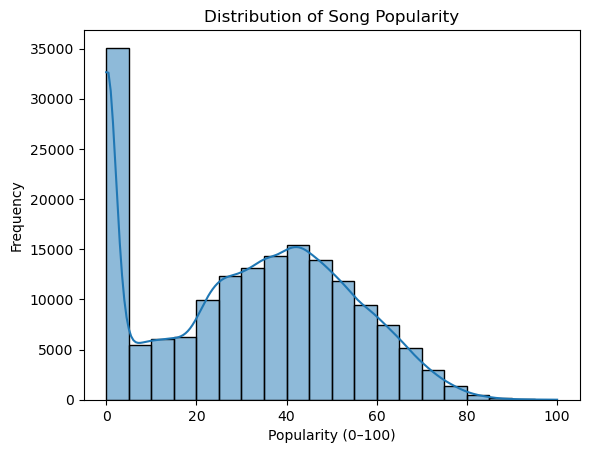

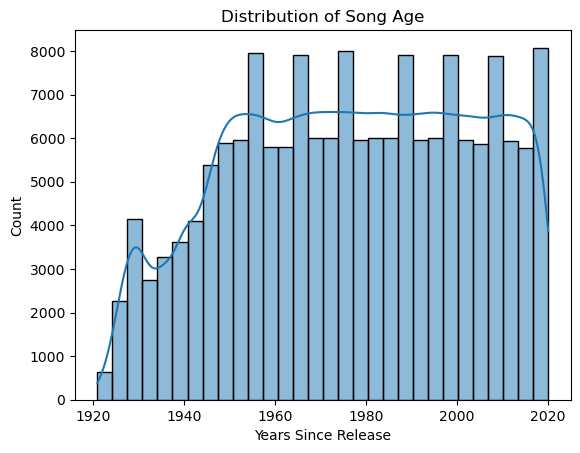

In [4]:
# Observe distribution of popularity scores and year

sns.histplot(df['popularity'], bins=20, kde=True)
plt.title("Distribution of Song Popularity")
plt.xlabel("Popularity (0–100)")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df['year'], bins=30, kde=True)
plt.title("Distribution of Song Age")
plt.xlabel("Years Since Release")
plt.ylabel("Count")
plt.show()

# Part III: Data Extraction and Preparation

## Data Extraction
Data was extracted from an existing, publicly available dataset hosted on Kaggle (Ay, Y. E., 2020). The dataset was downloaded as a CSV file and imported into a Python environment using the `pandas` library, which allowed for immediate access to over 160,000 rows of song data. The code for this is provided above.

## Data Preparation 
The following tools and techniques were used during data preparation:

- `pandas`: Loading, cleaning, filtering, and reshaping the dataset.
    - Checked data for missing or null values and duplicate entries.
    - Dropped columns that were irrelevant to the modeling process
        - `artists`: Potentially thousands of unique values which can create problems when encoding.
        - `id`: Unique identifier that does not contain any meaningful information about song characteristics.
        - `name`: Unstructured text that does not contain meaningful information.
        - `release_date`: Since about 30% of entries are missing the mm-dd component, this variable is redundant since we have `year`.
    - Re-encoded `release_year` as `song_age` by taking the difference 2025 - `release_year`.
- `NumPy`: Used sine and cosine to apply circular encoding transformations to the variable `key`.
- `scikit-learn`’s `train_test_split`: Used to split the data into training and testing sets to evaluate model generalizability, with 80% and 20% respectively.
- `scikit-learn`’s `StandardScaler`: Used to standardize numerical features (mean = 0, standard deviation = 1), ensuring consistent scale for all features. This was done within a `scikit-learn` pipeline, which first applied scaling before passing the transformed features to the Lasso regression model.

The code for the data preparation is provided below.

## Justification for Tools and Techniques

The use of Python and its data science ecosystem (primarily `pandas`, `scikit-learn`, and `NumPy`) is well justified due to their wide adoption in the industry and academia, as well as its extensive documentation. These tools were selected for their flexibility and ability to efficiently handle large datasets. 

Additionally, they provide seamless integration with visualization, modeling, and evaluation workflows, making them ideal for end-to-end data analyses. For example, the `NumPy` and `pandas` toolkits provided a straightforward means of implementing circular encoding for the musical key variable using sine and cosine transformations. This allowed for an accurate representation of cyclical relationships within a linear modeling context. A visualization of the transformation is provided below.

## One Advantage and One Disadvantage

A major advantage of the tools used here is that they allow for efficient and reproducible data cleaning and transformation, which is essential when working with a large, complex dataset. Transformations like circular encoding can be applied easily and consistently across the entire dataset. A disadvantage of the tools used here is that they do not enforce a strict schema by default like SQL. Since constraints are not enforced and must be coded explicitly, errors in the dataset can go unnoticed, such as a column that is categorical being interpreted as numeric.

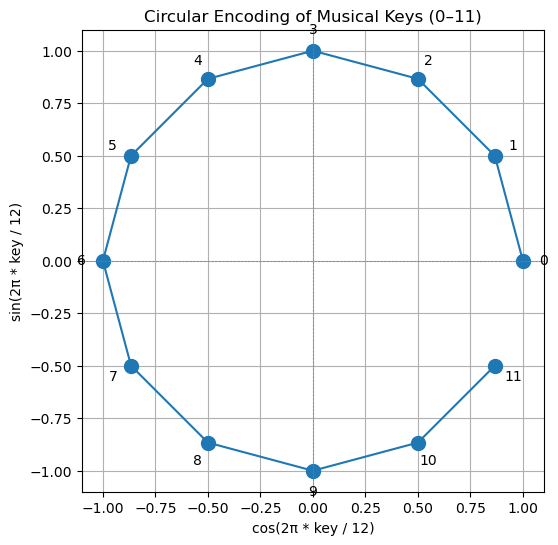

In [6]:
# Musical keys from 0 (C) to 11 (B)
keys = np.arange(12)
angles = 2 * np.pi * keys / 12
key_sin = np.sin(angles)
key_cos = np.cos(angles)

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(key_cos, key_sin, 'o-', markersize=10)
for i, key in enumerate(keys):
    plt.text(key_cos[i] * 1.1, key_sin[i] * 1.1, str(key), ha='center', va='center')

plt.title("Circular Encoding of Musical Keys (0–11)")
plt.xlabel("cos(2π * key / 12)")
plt.ylabel("sin(2π * key / 12)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

In [7]:
def printDupesNulls(data_frame):
# Detect duplicates and identify NAs and missing values with Pandas
    duplicate_count = data_frame.duplicated().sum()
    na_count = data_frame.isna().sum()
    missing_values_count = data_frame.isnull().sum()
    
    print('Number of duplicate rows:', duplicate_count)
    print('\nNumber of NAs per variable:')
    print(na_count)
    print('\nNumber of missing values per variable:')
    print(missing_values_count)


In [8]:
printDupesNulls(df)

Number of duplicate rows: 0

Number of NAs per variable:
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Number of missing values per variable:
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64


In [9]:
# Extract only the date strings matching yyyy-mm-dd
extracted = df['release_date'].str.extract(r'^(\d{4}-\d{2}-\d{2})$')[0]

# Use .notnull() on that Series and map to labels
df['date_format'] = extracted.notnull().map({True: 'yyyy-mm-dd', False: 'yyyy'})

# Count each format
format_counts = df['date_format'].value_counts()

print(format_counts)


date_format
yyyy-mm-dd    118188
yyyy           52465
Name: count, dtype: int64


In [10]:
# Circular Transformation of Key

df['key_sin'] = np.sin(2 * np.pi * df['key'] / 12).round(6)
df['key_cos'] = np.cos(2 * np.pi * df['key'] / 12).round(6)

In [11]:
# Re-encode release_year as song_age

df['song_age'] = 2025 - df['year']

In [12]:
# Drop irrelevant columns

unneeded_cols = ['artists', 'id', 'name', 'release_date', 'date_format', 'key', 'year']
df_reduced = df.drop(columns=unneeded_cols)

df_reduced.head()

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,key_sin,key_cos,song_age
0,0.0594,0.982,0.279,831667,0.211,0,0.878000,0.665,-20.096,1,4,0.0366,80.954,-0.866025,0.500000,104
1,0.9630,0.732,0.819,180533,0.341,0,0.000000,0.160,-12.441,1,5,0.4150,60.936,-0.500000,-0.866025,104
2,0.0394,0.961,0.328,500062,0.166,0,0.913000,0.101,-14.850,1,5,0.0339,110.339,1.000000,0.000000,104
3,0.1650,0.967,0.275,210000,0.309,0,0.000028,0.381,-9.316,1,3,0.0354,100.109,0.500000,-0.866025,104
4,0.2530,0.957,0.418,166693,0.193,0,0.000002,0.229,-10.096,1,2,0.0380,101.665,1.000000,0.000000,104


In [13]:
# Train/test split

X = df_reduced.drop(columns=['popularity'])
y = df_reduced['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)



# Part IV: Analysis

## Analysis Technique: Lasso Regression

To analyze the relationship between a song's audio features and its popularity, this project used Lasso regression (Least Absolute Shrinkage and Selection Operator). Lasso is a form of linear regression that applies L1 regularization, which adds a penalty equal to the absolute value of each coefficient (IBM, 2024). This encourages sparsity by shrinking the coefficients of less important features to zero.

Lasso performs automatic feature selection while fitting the model, which is particularly valuable in music data where features like `energy`, `loudness`, and `danceability` may be correlated or redundant. By simplifying the model, Lasso improves interpretability, handles multicollinearity effectively, and reduces the risk of overfitting. As a result, the model becomes more robust and generalizable while focusing only on the most predictive variables.

Before modeling, multicollinearity among the explanatory variables was evaluated using Variance Inflation Factors. All features had VIF values below 5, with the highest at 3.2, indicating low to moderate multicollinearity. This supports the use of multiple linear regression as a baseline, but to account for potential redundancy and improve model interpretability, Lasso regression was implemented as well.

To implement the analysis, a pipeline was created using `scikit-learn` that combined feature scaling with model fitting. The pipeline first applied `StandardScaler` to normalize all numeric features, ensuring they were on the same scale. This step was critical because Lasso regression is sensitive to feature magnitude due to the regularization term.

The pipeline then passed the standardized features into `LassoCV`, which automatically selected the optimal regularization strength (alpha) using 5-fold cross-validation. This cross-validation process helped ensure that the model generalizes well to unseen data by training and validating the model on multiple subsets of the dataset. Embedding both scaling and model fitting in the pipeline ensured consistency, reproducibility, and avoided data leakage during evaluation.

To better understand the impact of regularization and feature selection, an ablation test was conducted comparing Lasso regression to standard multiple linear regression (MLR), which was also created with a `scikit-learn` pipeline. Both models were trained on the same standardized feature set and evaluated using the same test set. This comparison allows us to isolate the effect of Lasso's regularization and feature selection capabilities. The $R^2$ score, mean absolute error, and root mean squared error were calculated below for both models using functions from `scikit-learn`'s module `metrics`, which were wrapped in a user-defined function, `evaluate_model`, defined below. In addition to printing the $R^2$, MAE, and RMSE, the `evaluate_model` function also prints the best regularization strength, $\alpha$, for the Lasso model, which represents how much penalty is applied to the size of the coefficients.

## Justification of Analysis Technique

Lasso Regression was chosen for several key reasons:

- Feature Selection: Lasso zeroes out less influential features, making it ideal for identifying which song characteristics have the strongest relationship with popularity.
- Model Interpretability: It is easier to communicate findings to non-technical stakeholders with a simplified model.
- Overfitting Control: The regularization term helps prevent overfitting, especially important in datasets with many variables.
- Integration with Scikit-Learn Pipeline: Lasso can be easily implemented with cross-validation and scaling using Python’s `scikit-learn`, ensuring reproducible and efficient analysis.

## One Advantage and One Disadvantage of Lasso

An advantage of using Lasso regression is the automatic variable selection. Lasso helps reduce model complexity and focuses attention on the most meaningful predictors by excluding those with minimal influence. One disadvantage of Lasso regression is its sensitivity to correlated features. When features are highly correlated, Lasso may arbitrarily select one over others, potentially omitting important variables that are collinear with the selected ones.


In [15]:
# Unscaled feature matrix
X_vif = add_constant(X)  # adds intercept term
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(X.shape[1])]  # skip intercept

print(vif_data)


             Feature       VIF
0            valence  2.048222
1       acousticness  3.042613
2       danceability  1.967575
3        duration_ms  1.077035
4             energy  4.953524
5           explicit  1.407140
6   instrumentalness  1.358414
7           liveness  1.098782
8           loudness  3.202705
9               mode  1.018236
10       speechiness  1.544530
11             tempo  1.109815
12           key_sin  1.005875
13           key_cos  1.007731
14          song_age  2.071134


In [16]:
# Lasso pipeline with scaling and cross-validation
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LassoCV(cv=5, random_state=42))
])

# Standard multiple linear regression pipeline
mlr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])


# Fit the pipelines
lasso_pipeline.fit(X_train, y_train)

mlr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [17]:
def evaluate_model(pipeline, X_test, y_test, model_name='Model'):
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # get alpha value for Lasso model
    model = pipeline.named_steps['model']
    best_alpha = getattr(model, 'alpha_', None)
    
    # Print metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"--------------------------")
    print(f"R2 Score    :   {r2:.4f}")
    print(f"MAE         :   {mae:.4f}")
    print(f"RMSE        :   {rmse:.4f}")
    if best_alpha is not None:
        print(f"Best Alpha  :   {best_alpha:.4f}")
    
    # Coefficient summary
    feature_names = X_test.columns.tolist()
    coefficients = model.coef_
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=np.abs, ascending=False)
    
    return coef_df
    # , {
    #     'R2': r2,
    #     'MAE': mae,
    #     'RMSE': rmse,
    #     'Best Alpha': best_alpha
    # }
    

In [18]:
evaluate_model(lasso_pipeline, X_test, y_test, model_name='Lasso')


Lasso Performance Metrics:
--------------------------
R2 Score    :   0.7535
MAE         :   8.0057
RMSE        :   10.8039
Best Alpha  :   0.0188


,Feature,Coefficient
14,song_age,-17.322618
1,acousticness,-1.483661
6,instrumentalness,-1.305151
10,speechiness,-1.221607
7,liveness,-0.527836
2,danceability,0.471369
4,energy,-0.293935
5,explicit,0.224595
0,valence,0.129964
9,mode,-0.088836


In [19]:
evaluate_model(mlr_pipeline, X_test, y_test, model_name='MLR')


MLR Performance Metrics:
--------------------------
R2 Score    :   0.7535
MAE         :   8.0065
RMSE        :   10.8046


,Feature,Coefficient
14,song_age,-17.334750
1,acousticness,-1.568587
6,instrumentalness,-1.302523
10,speechiness,-1.251803
7,liveness,-0.528661
4,energy,-0.466811
2,danceability,0.455595
5,explicit,0.247448
0,valence,0.174573
9,mode,-0.111268


# Part V: Data Summary and Implications
This project evaluated whether selected audio features significantly influence Spotify song popularity. Using a dataset of over 160,000 songs with normalized audio features, two regression models were trained and compared: Lasso regression with cross-validated L1 regularization, and ordinary multiple linear regression. The goal was to determine whether regularization improved generalizability or interpretability without sacrificing accuracy.

Both models were trained on the same standardized feature set and tested on a holdout set. The results are as follows:

| Metric | Lasso | MLR |
| ----- | ----- | ----- |
| $R^2$ | 0.7535 | 0.7535 |
| MAE | 8.0057 | 8.0065 |
| RMSE | 10.8039 | 10.8046 |
| Best alpha | 0.0188 | NA |

These results indicate nearly identical predictive performance between the two models, with Lasso performing slightly better across all metrics. With an $R^2$ of 0.7535, both models explain a substantial portion of the variance in song popularity. The MAE and RMSE values suggest that the models predict popularity scores within about 8–11 points on average, on a scale of 0–100. 

The Lasso model selected an optimal alpha of 0.0188, applying only mild regularization. As a result, all features were retained except `key_sin`, which had a coefficient of zero. This low alpha value suggests that most features contribute meaningful signal to the target variable, and more aggressive regularization would have hurt performance.

To assess the stability of the MLR model, a multicollinearity check using VIF was performed. All features had VIF values below 5 (maximum = 3.2), indicating low multicollinearity, and supporting the validity of both linear modeling approaches.

## Feature Impact and Interpretation

The features with the highest absolute coefficients in the Lasso model included:

- `song_age` (negative correlation)
- `acousticness`
- `instrumentalness`
- `speechiness`
- `danceability`

These results are consistent with music industry trends; newer songs tend to dominate streaming platforms, and audio characteristics such as instrumentation and vocal presence influence engagement. While some of these features may be correlated, the low regularization strength selected by Lasso indicates that most features contributed meaningful signal to the model. As a result, Lasso preserved most of the full feature set while still slightly improving generalization performance.

## Limitations

One limitation of this analysis is that the popularity score is proprietary to Spotify, and its calculation is not fully transparent. It likely reflects not only user engagement metrics such as streams and skips, but also algorithmic promotion factors like playlist placement and editorial curation, which were not captured in the dataset. 

Furthermore, the models used in this project were limited to linear regression techniques, which do not account for potential interaction effects or non-linear relationships between variables. Another constraint was the lack of contextual or marketing-related features, such as artist fame, label support, social media presence, or release strategy, all of which may significantly influence a song’s popularity. 

Although musical key variable was circularly encoded using sine and cosine transformations, the Lasso model dropped the `key_sin` component entirely. This effectively reduced the circular encoding to a single projection, `key_sin`, eliminating half of the angular information and undermining the integrity of the cyclical representation. As a result, the remaining feature may not preserve the true cyclical nature of musical keys, potentially limiting the model’s ability to capture meaningful relationships between key signature and popularity.

## Recommendations and Future Work

Given that audio features alone explain a substantial portion of song popularity, an actionable next step would be to integrate audio-based modeling into early-stage music evaluation pipelines or recommendation systems. Stakeholders in music production and marketing could use such models to identify songs with strong engagement potential based solely on their acoustic characteristics.

To improve predictive accuracy and capture more complex relationships, future work should explore non-linear modeling approaches such as random forests or neural networks. These models can account for interactions between audio features and better model diminishing returns, thresholds, or synergistic effects that linear regression cannot detect.

Additionally, incorporating contextual and external variables (such as artist popularity, label affiliation, playlist inclusion, release strategy, or social media engagement) could significantly enhance model performance. These factors often play a major role in a song’s success but were not available in the current dataset.

Finally, revisiting the representation of musical key may be warranted. Since only one half of the circular encoding was removed by Lasso, the remaining feature may no longer preserve the full cyclical structure. Future work could test alternative encodings or evaluate whether musical key contributes meaningfully to popularity prediction at all.

## Acknowledgement of Sources

Ay, Y. E. (2020). Spotify Dataset 1921-2020, 160k+ Tracks. Kaggle.com. https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-1921-2020-160k-tracks

Brownlee, J. (2020, October 11). How to Develop LASSO Regression Models in Python. Machine Learning Mastery. https://machinelearningmastery.com/lasso-regression-with-python/

Nagpal, A. (2017, October 13). L1 and L2 Regularization Methods. Medium; Towards Data Science. https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

sklearn.linear_model.LassoCV — scikit-learn 0.24.1 documentation. (n.d.). Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

What is lasso regression? | IBM. (2024, January 18). IBM. https://www.ibm.com/topics/lasso-regression